In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk

In [51]:
from normalization import normalize_corpus

In [9]:
movie_data =  pd.read_csv('movieDescriptionDataSet.tsv', sep='\t')

In [87]:
movie_titles = movie_data['Title'].tolist();
movie_synopses = movie_data['Description'].tolist()
movie_genre = movie_data['Genre'].tolist()

In [15]:
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

In [64]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [66]:
vectorizer = TfidfVectorizer(max_features=1000)
feature_matrix = vectorizer.fit_transform(norm_movie_synopses).astype(float)

In [67]:
print (feature_matrix.shape) 


(100, 1000)


In [68]:
feature_names = vectorizer.get_feature_names()


In [69]:
print (feature_names[:20])


['11th', 'abbey', 'accidentally', 'across', 'act', 'action', 'activity', 'adventure', 'african', 'agent', 'alex', 'ally', 'alter', 'amber', 'america', 'american', 'among', 'and', 'another', 'apart']


In [70]:
from sklearn.cluster import KMeans

In [71]:
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [82]:
num_clusters = 40

In [77]:
distortions = []
K = range(1, 100)
for i in K:
    kmeans = KMeans(n_clusters = i, max_iter=10000)
    kmeans.fit(feature_matrix)
    distortions.append(kmeans.inertia_)

In [49]:
%matplotlib inline

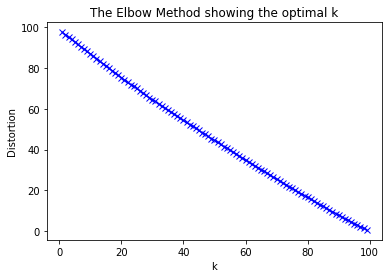

In [78]:
import matplotlib.pyplot as plt

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [83]:
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

In [84]:
from collections import Counter


In [88]:
c = Counter(clusters)
print (c.items())

dict_items([(6, 2), (30, 3), (32, 2), (28, 2), (23, 4), (3, 4), (25, 2), (15, 2), (24, 3), (2, 2), (26, 4), (38, 4), (12, 4), (0, 3), (17, 5), (21, 6), (5, 3), (18, 1), (9, 4), (7, 3), (39, 3), (35, 2), (16, 3), (14, 3), (4, 4), (19, 3), (8, 1), (13, 1), (1, 3), (36, 1), (20, 2), (11, 2), (29, 1), (22, 1), (31, 1), (10, 1), (27, 1), (33, 2), (37, 1), (34, 1)])


In [89]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        genres = movie_data[movie_data['Cluster'] == cluster_num]['Genre'].values.tolist()
        
        cluster_details[cluster_num]['movies'] = movies
        cluster_details[cluster_num]['genres'] = genres
    
    return cluster_details
        
       
    
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print ('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        
        print ('Movie genres:')
        print (', '.join(cluster_details['genres']))

        
        print ('='*40)

cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['runner', 'defend', 'drug', 'long', 'dangerous']
Movies in this cluster:
The Equalizer 2, Braven, Blade Runner 2049
Movie genres:
Thriller, Drama, Science Fiction
Cluster 1 details:
--------------------
Key features: ['family', 'run', 'dinosaur', 'former', 'clark']
Movies in this cluster:
Jurassic World: Fallen Kingdom, Skyscraper, National Lampoon's Christmas Vacation
Movie genres:
Action, Action, Comedy
Cluster 2 details:
--------------------
Key features: ['haunt', 'final', 'nun', 'abbey', 'strode']
Movies in this cluster:
Halloween, The Nun
Movie genres:
Thriller, Horror
Cluster 3 details:
--------------------
Key features: ['face', 'yet', 'spring', 'action', 'challenge']
Movies in this cluster:
Bohemian Rhapsody, Incredibles 2, Johnny English Strikes Again, Now You See Me 2
Movie genres:
Drama, Action, Adventure, Action
Cluster 4 details:
--------------------
Key features: ['evil', 'battle', 'guy', 'bad', 'wisecrack']
Movies i

In [91]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

/Users/brunosalazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


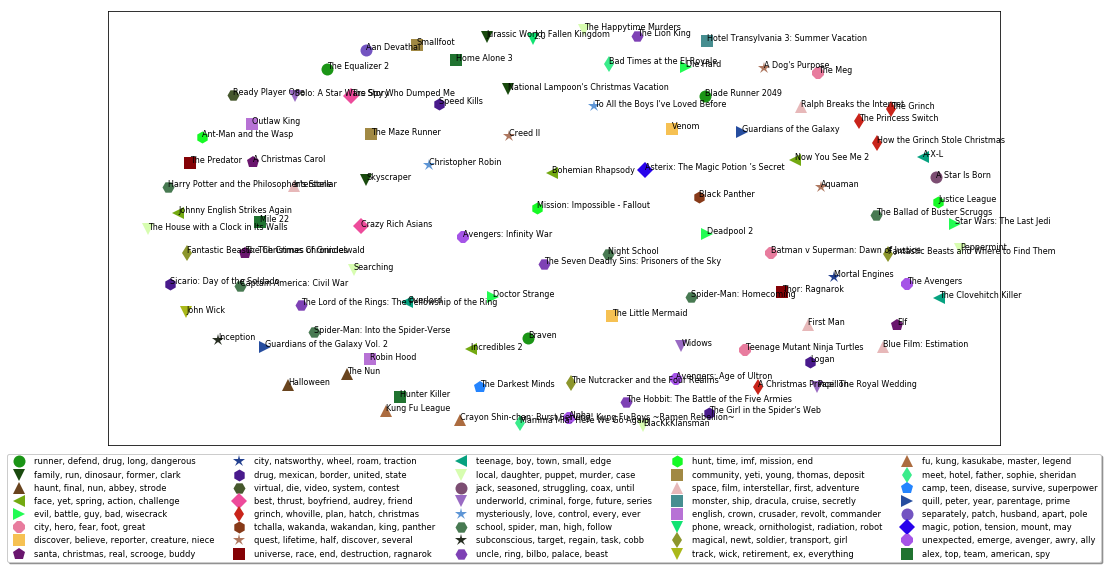

In [92]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))  